# Evaluate

The main evaluation notebook to compare agents and baseline algorithm performances.

In [4]:
import gymnasium as gym
import sqlite3
from stable_baselines3 import A2C, SAC, PPO
from stable_baselines3.common.callbacks import CheckpointCallback

import pandas as pd
import numpy as np

# from calliope.envs.bidstack_joint_env import MeritOrderJointNEMEnv
from calliope.envs.bidstack_joint_reg_env import MeritOrderJointNEMEnv

from calliope.envs.bidstack_energy_only_env import MeritOrderEnergyNEMEnv

from calliope.optimisation.config import load_config

from calliope.sac_constrained import SACC

from calliope.data import DataManager
from calliope.market import MeritOrderNEM
import datetime

con = sqlite3.connect('E:/Code/Calliope/notebooks/historical_mms.db')
start_date = '2019/07/01 00:00:00'
# end_date = '2019/01/03 00:00:00'
end_date = '2019/09/01 00:00:00'
region = 'NSW1'

print('Loading data')
data_manager = DataManager(con)
data_manager.load_data(start_date, end_date, region, nem_solve_data=True)
nem = MeritOrderNEM(data_manager)
nem.build()

nem.load_bids_from_pickle(
    [f'E:/Code/Calliope/notebooks/bid_dict_{i}_nsw.pkl' for i in ['jul', 'aug']]
)
    # [f'E:/Code/Calliope/notebooks/bid_dict_{i}_nsw.pkl' for i in ['jan', 'feb', 'mar', 'apr', 'may']]




Loading data


In [3]:
RESULTS_PATH = 'E:/Code/Calliope/results'

In [4]:
from calliope.envs.bidstack_joint_fcas_env import MeritOrderJointNEMEnv


In [10]:
bess_config = load_config('E:/Code/Calliope/scripts/config_pricemaker.yml')
# bess_config = load_config('E:/Code/Calliope/scripts/config.yml')

print('Loading env')
env = MeritOrderJointNEMEnv(
    nem = nem,
    bess_config = bess_config,
    verbose=False,
    episodic=False,
    init_interval=0
)

# env = MeritOrderEnergyNEMEnv(
#     nem = nem,
#     bess_config = bess_config,
#     verbose=True,
#     episodic=False,
#     init_interval=0
# )

Loading env


In [2]:
import importlib
import calliope.data 
importlib.reload(calliope.data)

<module 'calliope.data' from 'E:\\Code\\Calliope\\calliope\\data.py'>

In [5]:
from calliope.defaults import MARKETS, MARKETS_REG
from calliope import mpc

In [60]:
import tqdm
# model_name = 'E:/Code/Calliope/logs/SAC_JOINT_JantoJune_PM_fc_alt_70000_steps.zip'
model_loc = 'C/logs/'
# model_name = 'SAC_ENERGY_JantoJune_PM_fc_violateSOCReward_57000_steps.zip'
# model_name = 'SAC_JOINT_JantoJune_PM_reg_fullcap_no_tday_2_19000_steps.zip'
# model_name = 'SAC_JOINT_JantoJune_PT_all_arb_indicator_noreg_232000_steps'


model_name = 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_160000_steps'

model_path = f'{model_loc}{model_name}.zip'

# model_name = 'E:/Code/Calliope/logs/SAC_JantoJune_PT_fc_10200_steps.zip'506
model = SAC.load(model_path, env=env)

# options for reset()
vec_env = model.get_env()
obs = vec_env.reset()
allobs = []
allactions = []
all_prices = []
all_dispatch = []
soc_track = []
dispatch_intervals = []
all_bids = []

for i in tqdm(range(len(data_manager.dispatch_intervals))):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)

    # track all observations and actions
    allobs.append(obs)
    allactions.append(action)

    # track all prices, dispatched amounts, state of charge and timestamp
    all_prices.append(info[0]['prices'])
    all_dispatch.append(info[0]['dispatched_services'])
    soc_track.append(obs[:,0][0])
    dispatch_intervals.append(info[0]['di'])  
    all_bids.append(info[0]['q_bids'])  

env.reset()

dispatch_df = pd.DataFrame(all_dispatch, columns = [f'{m}_dispatch' for m in MARKETS])
prices_df = pd.DataFrame(all_prices, columns = [f'{m}_price' for m in MARKETS])
soc_df = pd.DataFrame(soc_track, columns = ['SOC'])
di_df = pd.DataFrame(dispatch_intervals, columns = ['SETTLEMENTDATE'])
results_df = pd.concat([di_df, dispatch_df, prices_df, soc_df], axis=1)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
from tqdm import tqdm

In [62]:
# def evaluate_agent(model):

# options for reset()
vec_env = model.get_env()
obs = vec_env.reset()
allobs = []
allactions = []
all_prices = []
all_dispatch = []
soc_track = []
dispatch_intervals = []
all_bids = []

for i in tqdm(range(len(data_manager.dispatch_intervals))):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)

    # track all observations and actions
    allobs.append(obs)
    allactions.append(action)

    # track all prices, dispatched amounts, state of charge and timestamp
    all_prices.append(info[0]['prices'])
    all_dispatch.append(info[0]['dispatched_services'])
    soc_track.append(obs[:,0][0])
    dispatch_intervals.append(info[0]['di'])  
    all_bids.append(info[0]['q_bids'])  

env.reset()

dispatch_df = pd.DataFrame(all_dispatch, columns = [f'{m}_dispatch' for m in MARKETS])
prices_df = pd.DataFrame(all_prices, columns = [f'{m}_price' for m in MARKETS])
soc_df = pd.DataFrame(soc_track, columns = ['SOC'])
di_df = pd.DataFrame(dispatch_intervals, columns = ['SETTLEMENTDATE'])
results_df = pd.concat([di_df, dispatch_df, prices_df, soc_df], axis=1)

100%|██████████| 17857/17857 [02:25<00:00, 122.48it/s]


(array([5.00000000e-01, 2.64813632e-01, 2.04539031e-01, 2.88675278e-01,
        1.80457532e-01, 1.93805277e-01, 5.40969789e-01, 9.91778001e-02,
        1.02182046e-01, 1.64201651e-02, 5.12220025e-01, 4.49999992e-04,
        2.99999992e-05, 9.99999975e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.99999992e-05, 0.00000000e+00], dtype=float32),
 {})

In [63]:
dispatch_df = pd.DataFrame(all_dispatch, columns = [f'{m}_dispatch' for m in MARKETS])
prices_df = pd.DataFrame(all_prices, columns = [f'{m}_price' for m in MARKETS])
soc_df = pd.DataFrame(soc_track, columns = ['SOC'])
di_df = pd.DataFrame(dispatch_intervals, columns = ['SETTLEMENTDATE'])
results_df = pd.concat([di_df, dispatch_df, prices_df, soc_df], axis=1)

In [64]:
all_bids_dict = {}
for m in MARKETS:
    all_bids_dict[m] = []

all_bids_dict['SETTLEMENTDATE'] = []

for idx, row in di_df.iterrows():
    all_bids_dict['SETTLEMENTDATE'].append(row['SETTLEMENTDATE'])
    for m in MARKETS:
        all_bids_dict[m].append(all_bids[idx][m][0].quantity)


In [65]:
# bid dataframe
all_bids_df = pd.DataFrame(all_bids_dict)


In [66]:
all_bids_df.to_csv(f'{model_name}_bid_amounts.csv', index=False)

In [88]:
dispatch_df.RAISE5MIN_dispatch.mean()

11.294369999999986

In [89]:
all_bids_df.RAISE5MIN.mean()

103.5560591518879

In [101]:
from calliope.defaults import FCAS_SERVICES

In [225]:
# Cleared ratio
means = {
    'Bid Quantity': [],
    'Cleared Quantity': [],
    'Market': []
}
for m in FCAS_SERVICES:
    means['Bid Quantity'].append(round(all_bids_df[m].mean(),1))
    means['Cleared Quantity'].append(round(dispatch_df[f'{m}_dispatch'].mean(),1))
    means['Market'].append(m)


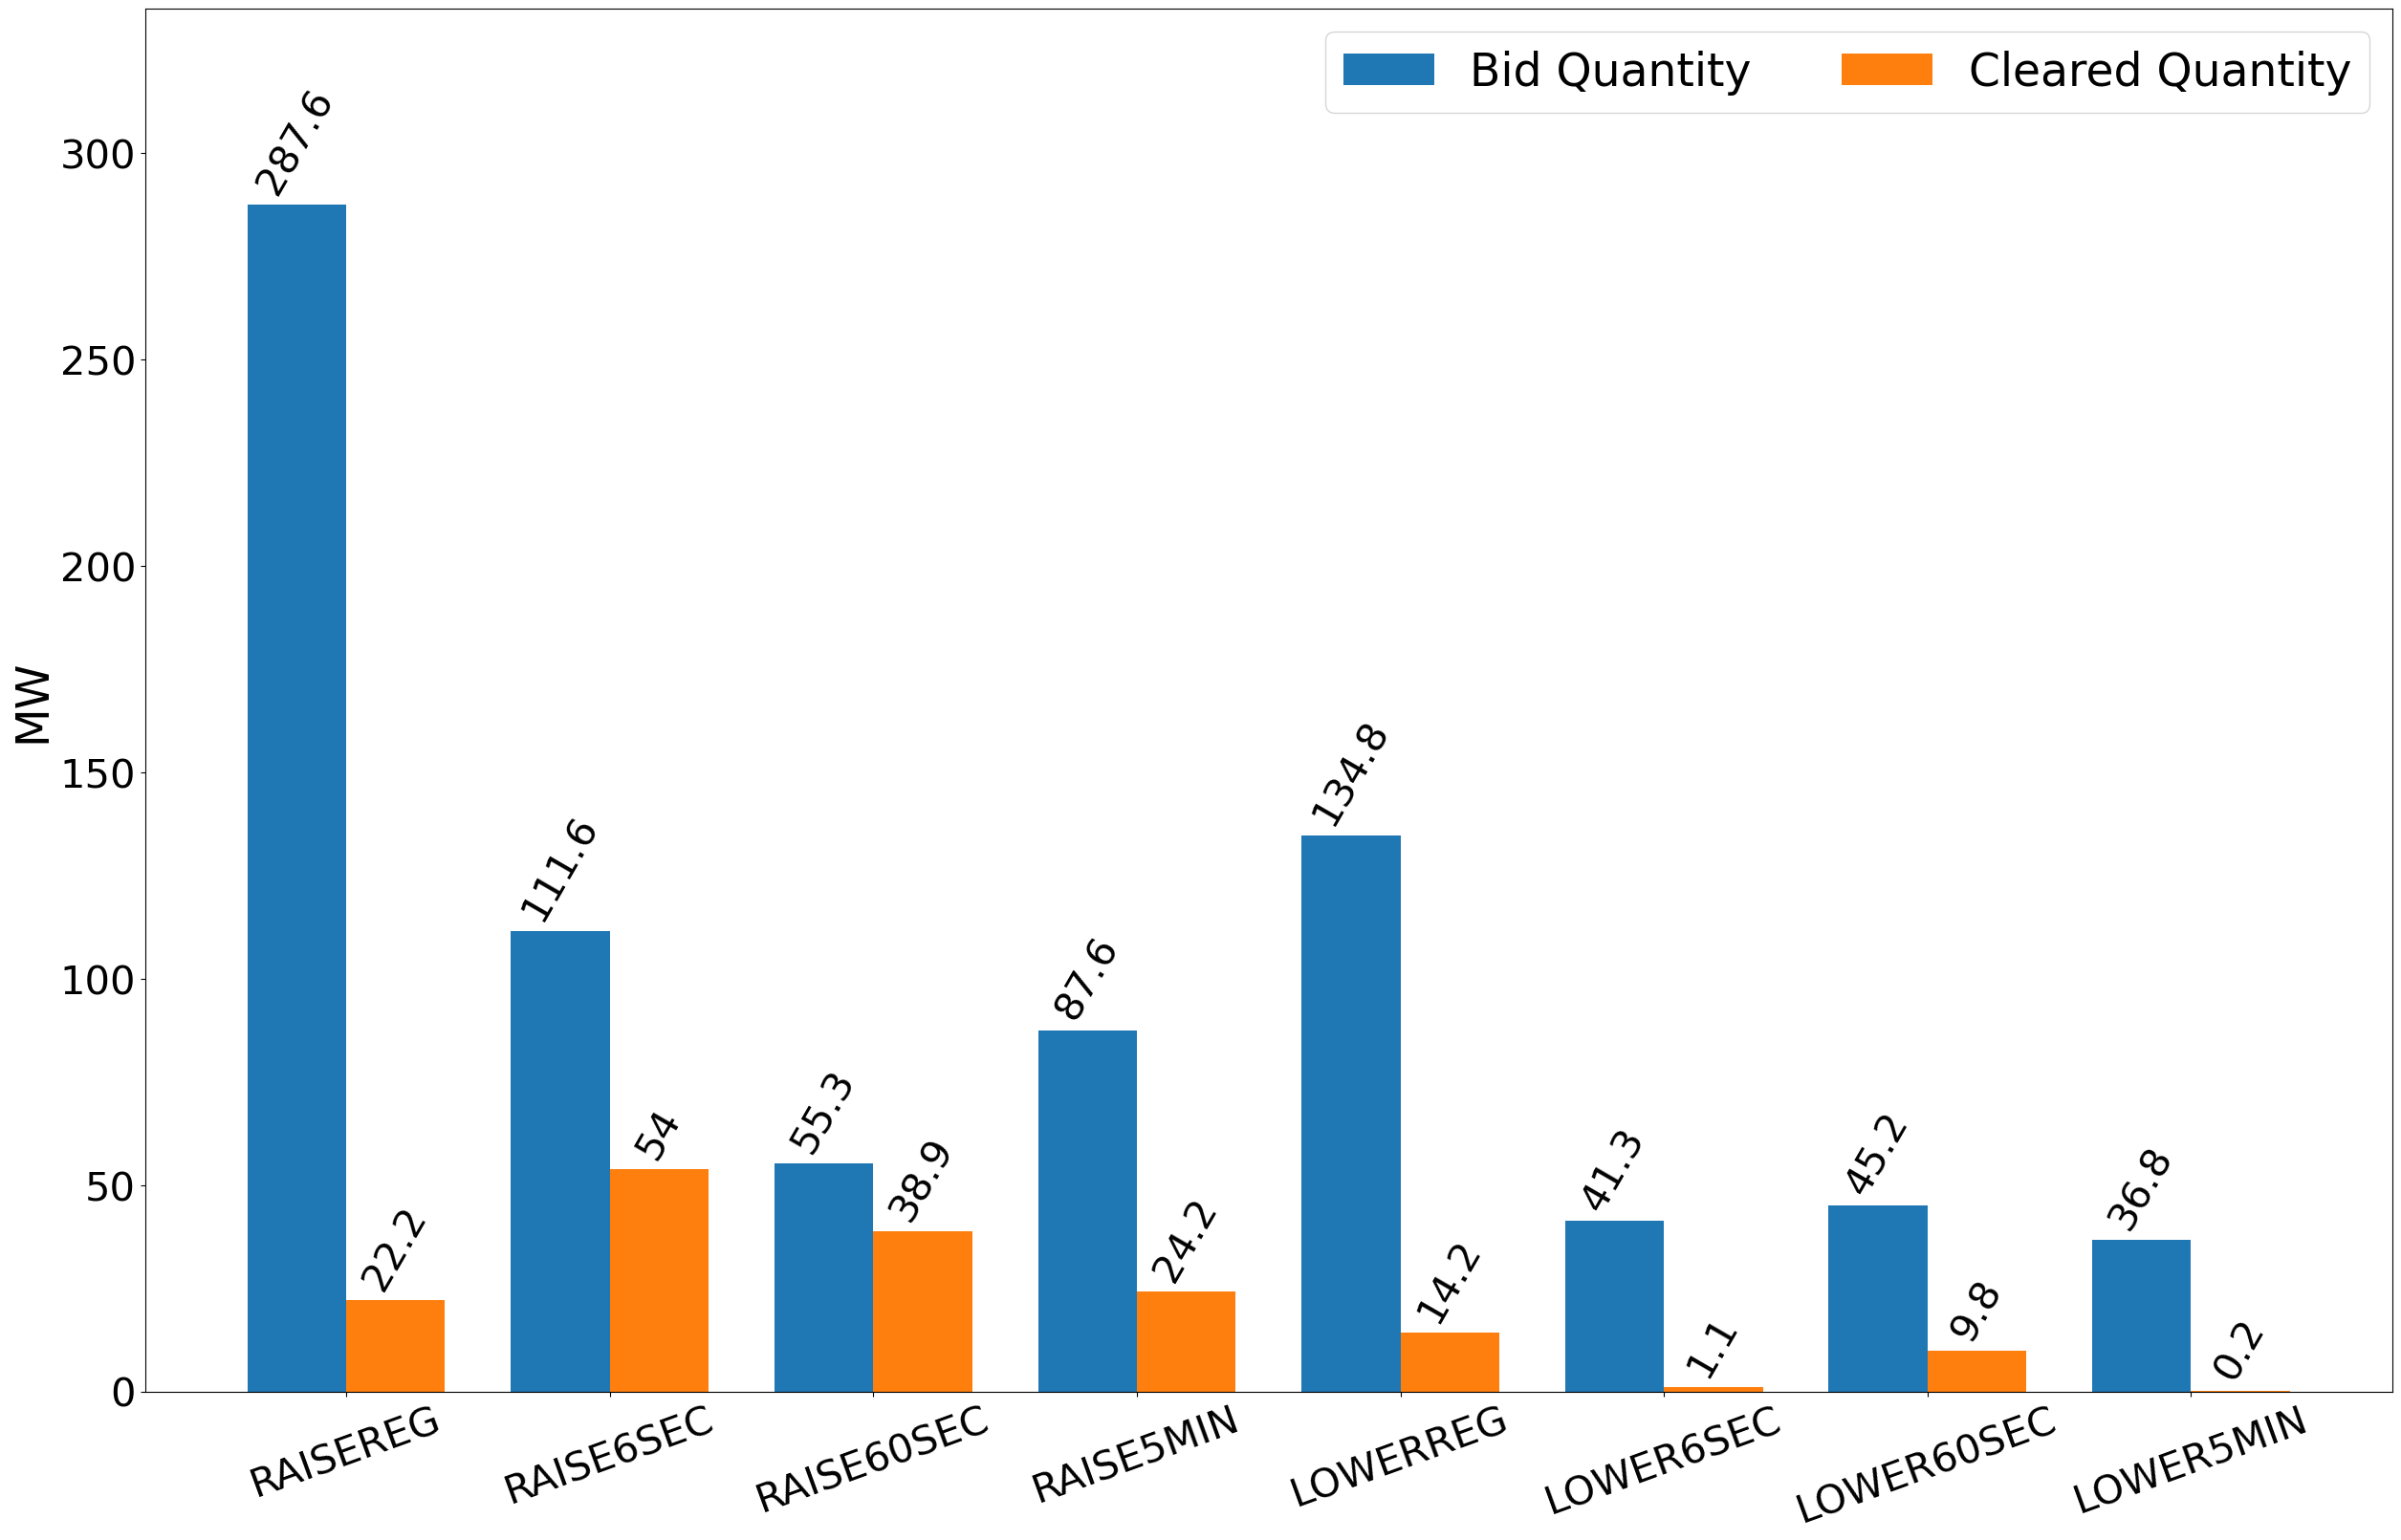

In [224]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(FCAS_SERVICES))*2  # the label locations
width = .75 # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize = (25,16), layout='constrained')

for attribute, measurement in means.items():
    if attribute == 'Market':
        continue

    offset = (width * multiplier)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize=30, rotation=60, label_type='edge')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MW', fontsize=34)
ax.yaxis.set_tick_params(labelsize=30)

# ax.set_title('Bid quantities against cleared')
ax.set_xticks(x + width, FCAS_SERVICES, fontsize=30, rotation=20)
ax.legend(loc='upper right', ncols=2, fontsize = 34)
ax.set_ylim(0, 335)

plt.show()

In [211]:
fig.savefig(f'{RESULTS_PATH}/bid_vs_cleared_quantities_fcas.png', dpi=250, bbox_inches='tight')

In [296]:
percentage_cleared = pd.DataFrame(1 -(results_df[[f'{m}_dispatch' for m in FCAS_SERVICES]].isin([0]).sum() / results_df.shape[0])).reset_index(names=['Market'])

In [298]:
percentage_cleared.columns = ['Market', 'Percentage Cleared']

In [324]:
print(((round(100*percentage_cleared['Percentage Cleared'], 3)).astype(str)+'\%').to_latex())

\begin{tabular}{ll}
\toprule
 & Percentage Cleared \\
\midrule
0 & 61.634\% \\
1 & 86.459\% \\
2 & 85.737\% \\
3 & 58.201\% \\
4 & 59.848\% \\
5 & 9.71\% \\
6 & 53.559\% \\
7 & 0.941\% \\
\bottomrule
\end{tabular}



In [320]:
# get fcas cleared amounts and market sizes
means_df = pd.DataFrame(means)
means_df['Bid Quantity (MW)'] = round(means_df['Bid Quantity'],2).astype(str)
means_df['Cleared Quantity (MW)'] = round(means_df['Cleared Quantity'],2).astype(str)
means_df['Percentage Cleared'] = (round(100*percentage_cleared['Percentage Cleared'], 3)).astype(str)+'\%'



print(means_df[['Market', 'Bid Quantity (MW)', 'Cleared Quantity (MW)', 'Percentage Cleared']].to_latex())
print(round(data_manager.fcas_requirements.describe(),2).reset_index(names='summary').query("summary in ('mean','max')")[FCAS_SERVICES].T.to_latex())

\begin{tabular}{lllll}
\toprule
 & Market & Bid Quantity (MW) & Cleared Quantity (MW) & Percentage Cleared \\
\midrule
0 & RAISEREG & 287.6 & 22.2 & 61.634\% \\
1 & RAISE6SEC & 111.6 & 54.0 & 86.459\% \\
2 & RAISE60SEC & 55.3 & 38.9 & 85.737\% \\
3 & RAISE5MIN & 87.6 & 24.2 & 58.201\% \\
4 & LOWERREG & 134.8 & 14.2 & 59.848\% \\
5 & LOWER6SEC & 41.3 & 1.1 & 9.71\% \\
6 & LOWER60SEC & 45.2 & 9.8 & 53.559\% \\
7 & LOWER5MIN & 36.8 & 0.2 & 0.941\% \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
 & 1 & 6 \\
\midrule
RAISEREG & 77.130000 & 215.540000 \\
RAISE6SEC & 67.160000 & 240.250000 \\
RAISE60SEC & 58.120000 & 229.250000 \\
RAISE5MIN & 149.290000 & 300.000000 \\
LOWERREG & 82.460000 & 221.690000 \\
LOWER6SEC & 6.390000 & 85.000000 \\
LOWER60SEC & 23.020000 & 127.250000 \\
LOWER5MIN & 27.620000 & 161.000000 \\
\bottomrule
\end{tabular}



In [12]:
from calliope.prices import construct_prices_from_merit_order_csv


prices = construct_prices_from_merit_order_csv(
    path='merit_order_prices.csv', 
    region_id= 'NSW1', 
    start_date = '2019/01/01', 
    end_date='2019/09/01', 
    create_agc=True
)
prices_df_comparison = prices.to_dataframe()

In [22]:
results_df = pd.read_csv(f'{RESULTS_PATH}/SAC_JOINT_JantoJune_PT_all_longtrain_322000_steps_results_df.csv')
results_df['SETTLEMENTDATE'] = pd.to_datetime(results_df['SETTLEMENTDATE'])
revenues = mpc.calculate_simulation_cumulative_revenue(results_df, markets_list=MARKETS)

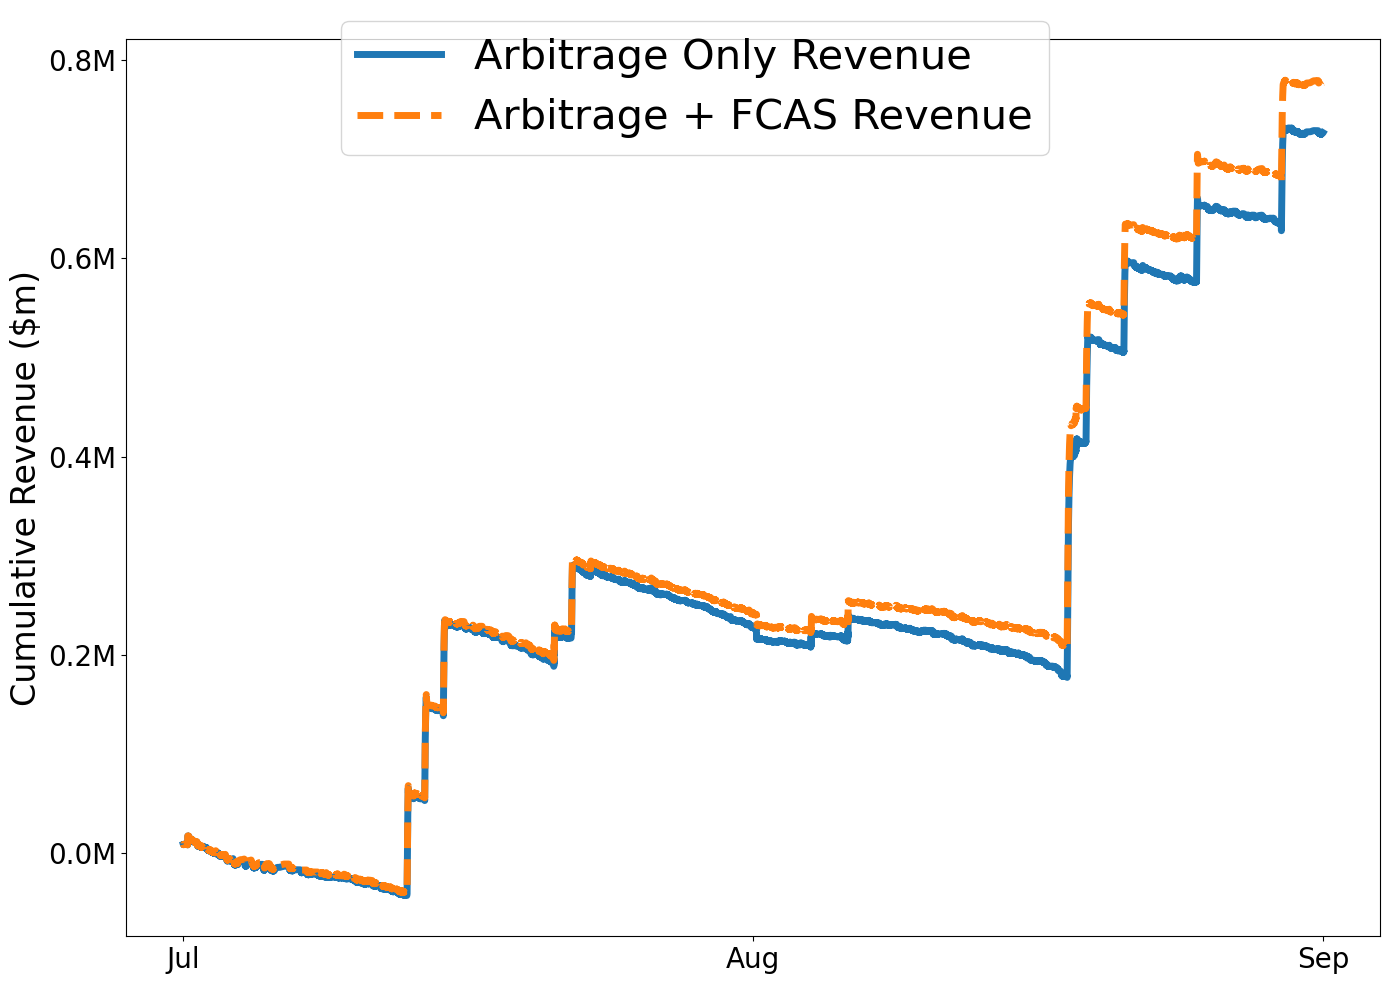

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
locater = mdates.MonthLocator(bymonth=[7,8,9])
myFmt = mdates.DateFormatter('%b')

from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(14,10))

ax.plot(revenues.SETTLEMENTDATE, revenues.ENERGY_revenue, label='Arbitrage Only Revenue', linewidth =5)
ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label='Arbitrage + FCAS Revenue', linewidth=5, linestyle='dashed')

# ax2 = ax.twinx()

# ax2.plot(results_df.SETTLEMENTDATE, results_df.ENERGY_price, color='r', alpha=0.3, label='Energy Price')
# ax.set_xlabel('SETTLEMENTDATE', fontsize=24)
ax.set_ylabel('Cumulative Revenue ($m)', fontsize=24)
# ax.set_ylabel('Price ($/MWh)', fontsize=24)

ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(locater)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_tick_params(labelsize=16)
# ax.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

fig.tight_layout()
# fig.suptitle("Price-Taker Energy-Reg Bidding Cumulative Revenue Jul-Aug", size=26)
fig.subplots_adjust(top=0.95)
fig.legend(fontsize=30, loc='upper center')

In [48]:
bess_config = load_config('E:/Code/Calliope/scripts/config_pricemaker.yml')
# bess_config = load_config('E:/Code/Calliope/scripts/config.yml')

print('Loading env')
env = MeritOrderJointNEMEnv(
    nem = nem,
    bess_config = bess_config,
    verbose=False,
    episodic=False,
    init_interval=0
)

summary_df = pd.DataFrame()

Loading env


In [52]:
from tqdm import tqdm

In [108]:
# Running full loop to get best model by 20000 steps. then can hone in
for steps in range(480000,500001,10000):
    model_name = f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_{steps}_steps'
    print(f'Running model {model_name}')
    model_path = f'{model_loc}{model_name}.zip'
    model = SAC.load(model_path, env=env)
    vec_env = model.get_env()
    obs = vec_env.reset()
    allobs = []
    allactions = []
    all_prices = []
    all_dispatch = []
    soc_track = []
    dispatch_intervals = []

    for i in tqdm(range(len(data_manager.dispatch_intervals))):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action)

        # track all observations and actions
        allobs.append(obs)
        allactions.append(action)

        # track all prices, dispatched amounts, state of charge and timestamp
        all_prices.append(info[0]['prices'])
        all_dispatch.append(info[0]['dispatched_services'])
        soc_track.append(obs[:,0][0])
        dispatch_intervals.append(info[0]['di'])

    env.reset()
    dispatch_df = pd.DataFrame(all_dispatch, columns = [f'{m}_dispatch' for m in MARKETS])
    prices_df = pd.DataFrame(all_prices, columns = [f'{m}_price' for m in MARKETS])
    soc_df = pd.DataFrame(soc_track, columns = ['SOC'])
    di_df = pd.DataFrame(dispatch_intervals, columns = ['SETTLEMENTDATE'])

    results_df = pd.concat([di_df, dispatch_df, prices_df, soc_df], axis=1)
    revenues = mpc.calculate_simulation_cumulative_revenue(results_df, markets_list=MARKETS)
    final_total_revenue = revenues.TOTAL.iloc[-1]

    results_df.to_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv', index=False)

    summary_df_i = pd.DataFrame(
        {'model_name': [model_name], 
         'steps': [steps], 
         'final_revenue': [final_total_revenue]}
    )
    print(summary_df_i)
    summary_df = pd.concat([summary_df, summary_df_i]).reset_index(drop=True)
    summary_df.to_csv('summary_df_final_cumulative_revenues.csv', index=False)
    
    

Running model SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_480000_steps
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


100%|██████████| 17857/17857 [02:36<00:00, 114.20it/s]


                                          model_name   steps  final_revenue
0  SAC_JOINT_JantoJune_PM_all_longtrain_arb_indic...  480000   9.478000e+06
Running model SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_490000_steps
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


100%|██████████| 17857/17857 [02:34<00:00, 115.59it/s]


                                          model_name   steps  final_revenue
0  SAC_JOINT_JantoJune_PM_all_longtrain_arb_indic...  490000  -8.138405e+06
Running model SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_500000_steps
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


100%|██████████| 17857/17857 [02:26<00:00, 121.77it/s]


                                          model_name   steps  final_revenue
0  SAC_JOINT_JantoJune_PM_all_longtrain_arb_indic...  500000  -77104.893123


In [58]:
summary_df.sort_values('final_revenue')['model_name'].tolist()

['SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_380000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_320000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_260000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_400000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_80000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_360000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_300000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_120000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_240000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_180000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_220000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_140000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_200000_steps',
 'SAC_JOINT_JantoJune_PM_all_longtrain_

In [165]:
model_name='SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_40000_steps'
results_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')

<Axes: >

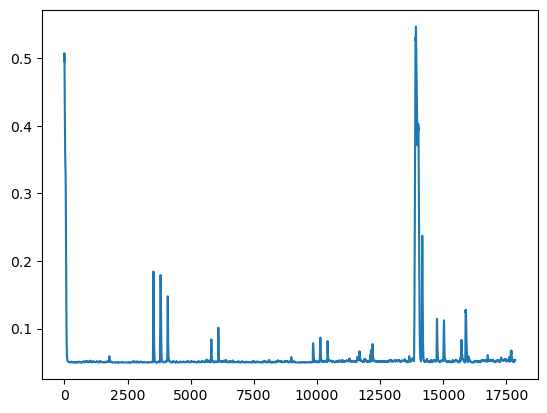

In [166]:
results_df.SOC.plot()

<Axes: >

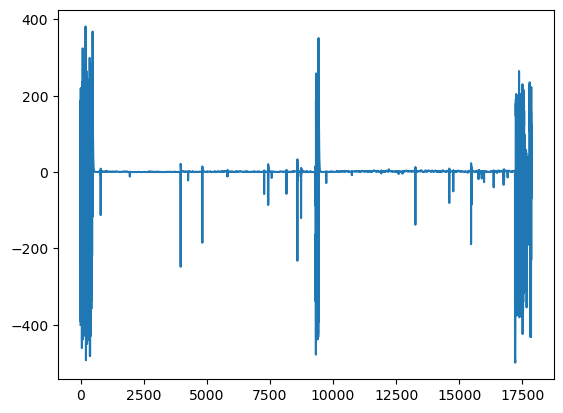

In [161]:
results_df.ENERGY_dispatch.plot()

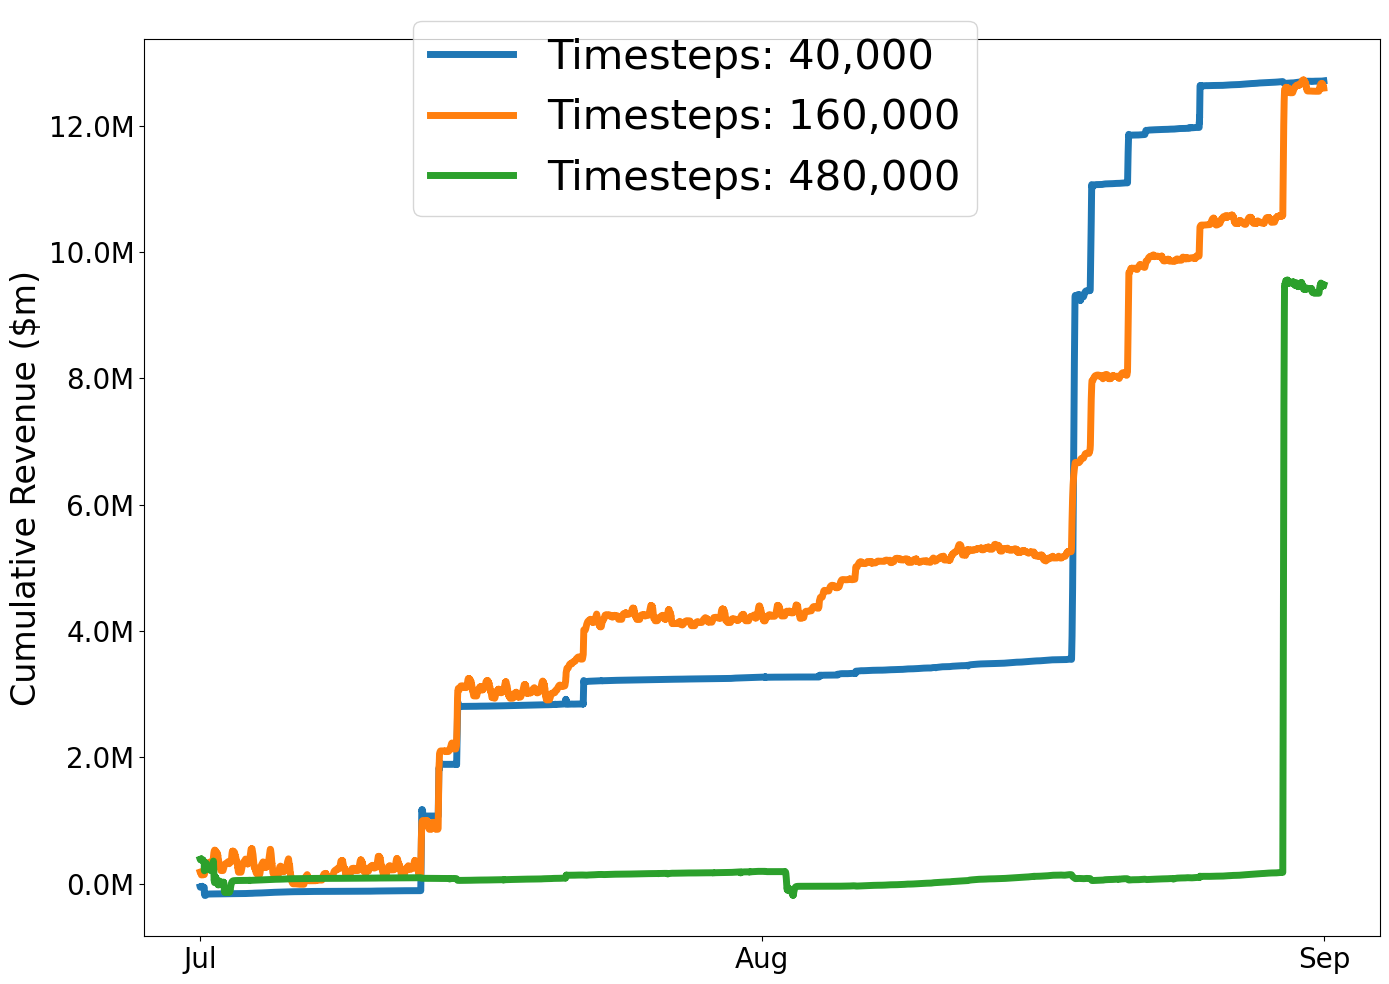

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
locater = mdates.MonthLocator(bymonth=[7,8,9])
myFmt = mdates.DateFormatter('%b')

from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(14,10))

timesteps = [40000,160000,480000]
for ts in timesteps:
    model_name=f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_{ts}_steps'
    results_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')
    revenues = mpc.calculate_simulation_cumulative_revenue(results_df, MARKETS)
    revenues['SETTLEMENTDATE'] = pd.to_datetime(revenues['SETTLEMENTDATE'])
    ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label=f'Timesteps: {ts:,}', linewidth =5)
# ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label='Joint', linewidth=5, linestyle='dashed')

# ax2 = ax.twinx()

# ax2.plot(results_df.SETTLEMENTDATE, results_df.ENERGY_price, color='r', alpha=0.3, label='Energy Price')
# ax.set_xlabel('SETTLEMENTDATE', fontsize=24)
ax.set_ylabel('Cumulative Revenue ($m)', fontsize=24)
# ax.set_ylabel('Price ($/MWh)', fontsize=24)

ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(locater)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_tick_params(labelsize=16)
# ax.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

fig.tight_layout()
# fig.suptitle("Price-Taker Energy-Reg Bidding Cumulative Revenue Jul-Aug", size=26)
fig.subplots_adjust(top=0.95)
fig.legend(fontsize=30, loc='upper center')
plt.show()

In [18]:
fig.savefig(f'{RESULTS_PATH}/{model_name}_pm_cumulative_fcas_revenues.png', bbox_inches='tight', dpi=250)


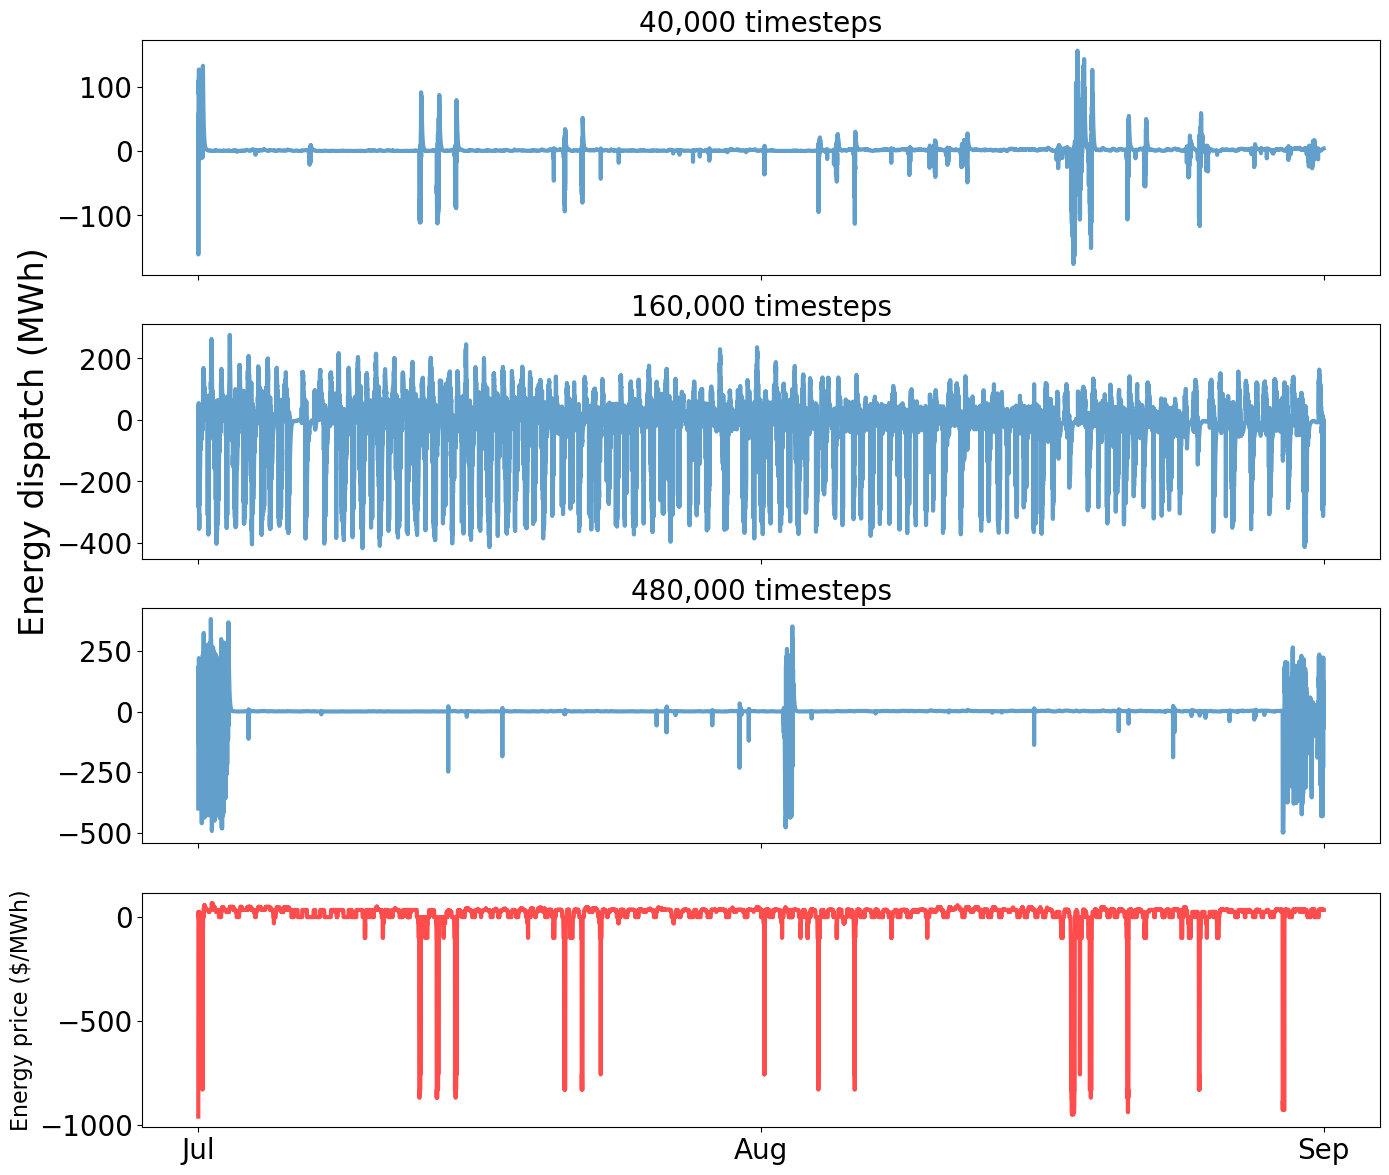

In [212]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
locater = mdates.MonthLocator(bymonth=[7,8,9])
myFmt = mdates.DateFormatter('%b')

from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(4,1, figsize=(14,12), sharex=True)

ls=['-','--','-.',':']
lw = [6,2,4]
timesteps = [40000,160000,480000]
for i in range(len(timesteps)):
    ts = timesteps[i]
    model_name=f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_{ts}_steps'
    results_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')
    results_df['SETTLEMENTDATE'] = pd.to_datetime(results_df['SETTLEMENTDATE'])
    #revenues = mpc.calculate_simulation_cumulative_revenue(results_df, MARKETS)
    ax[i].plot(
        results_df.SETTLEMENTDATE, 
        results_df.ENERGY_dispatch, 
        label=f'Timesteps: {ts:,}', 
        linewidth =3, 
        alpha=0.7,
        # linestyle=ls[i]
    )
    if i == 1:
        ax[i].set_ylabel('Energy dispatch (MWh)', fontsize=24)
    # ax.set_ylabel('Price ($/MWh)', fontsize=24)

    if i ==2:
        ax[i].xaxis.set_tick_params(labelsize=20)
        ax[i].xaxis.set_major_formatter(myFmt)
        ax[i].xaxis.set_major_locator(locater)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_title(f'{ts:,} timesteps', fontsize=20)
# ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label='Joint', linewidth=5, linestyle='dashed')

i=3
ax[i].plot(
    results_df.SETTLEMENTDATE, 
    results_df.ENERGY_price, 
    label=f'Energy price', 
    linewidth =3, 
    alpha=0.7,
    color='red'
    # linestyle=ls[i]
)

ax[i].xaxis.set_tick_params(labelsize=20)
ax[i].xaxis.set_major_formatter(myFmt)
ax[i].xaxis.set_major_locator(locater)
ax[i].yaxis.set_tick_params(labelsize=20)
ax[i].set_ylabel('Energy price ($/MWh)', fontsize=16)
# ax[i].set_title(f'Energy price', fontsize=20)
# ax2 = ax.twinx()

# ax2.plot(results_df.SETTLEMENTDATE, results_df.ENERGY_price, color='r', alpha=0.3, label='Energy Price')
# ax.set_xlabel('SETTLEMENTDATE', fontsize=24)

# ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_tick_params(labelsize=16)
# ax.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

fig.tight_layout()
# fig.suptitle("Price-Taker Energy-Reg Bidding Cumulative Revenue Jul-Aug", size=26)
fig.subplots_adjust(top=0.95)
# fig.legend(fontsize=30, loc='upper center')
plt.show()

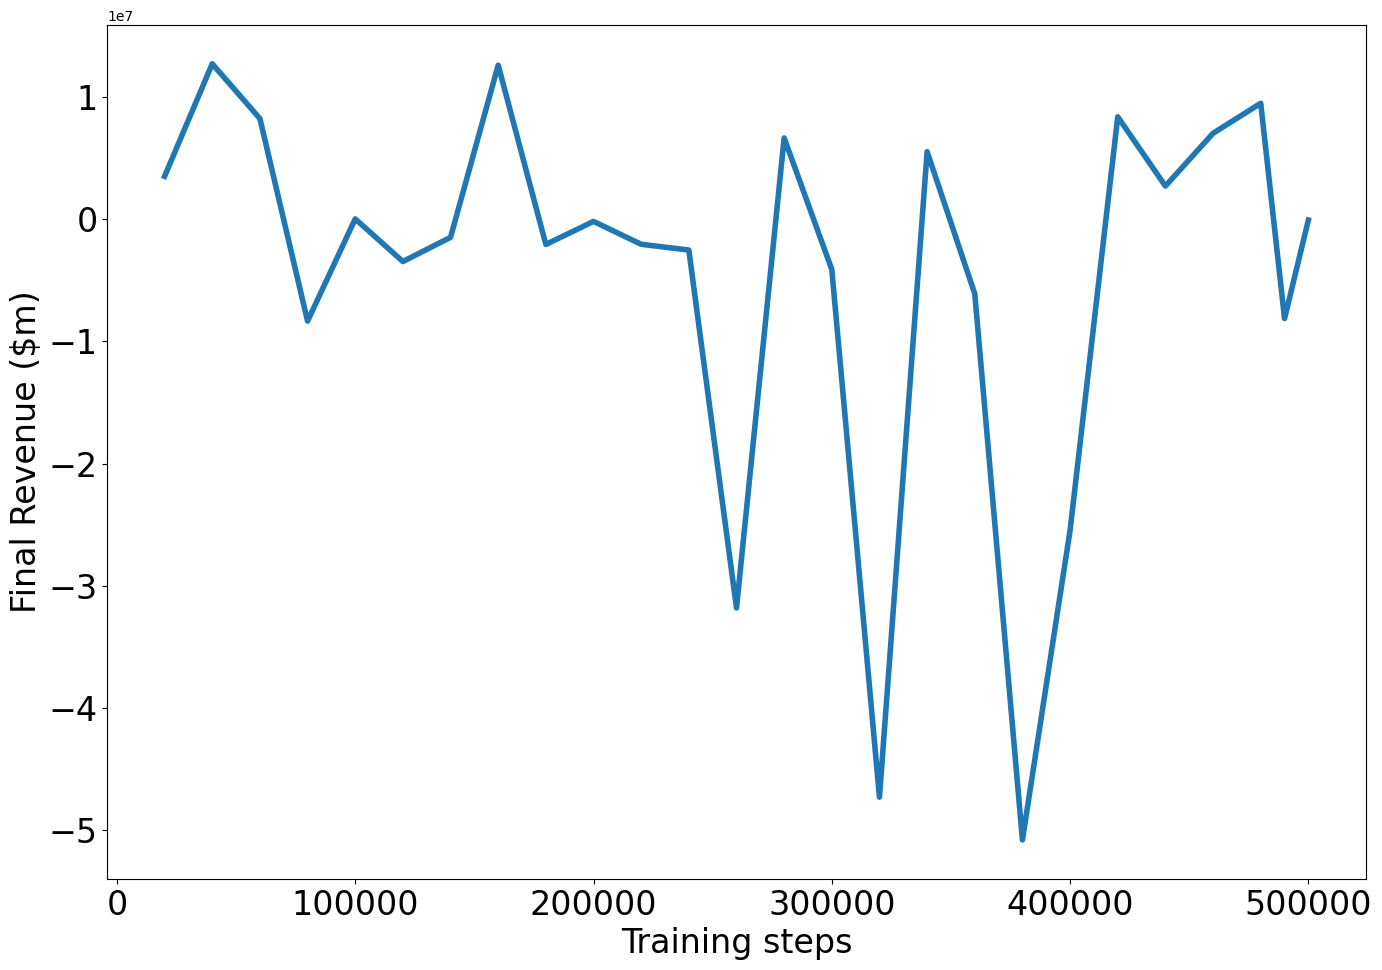

In [114]:
# Energy price and SOC chart 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,10))

ax.plot(summary_df.steps, summary_df.final_revenue, linewidth=4)

ax.set_xlabel('Training steps', fontsize=24)
ax.set_ylabel('Final Revenue ($m)', fontsize=24)
# ax2.set_ylabel('State of Charge (%)', fontsize=24)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)


# ax.yaxis.set_major_formatter(formatter)
fig.tight_layout()
# fig.suptitle("Energy Price against SoC on Jul 2nd", size=20)
fig.subplots_adjust(top=0.95)

# fig.savefig(f'{RESULTS_PATH}/{model_name}_sampleday{day}_soc_price_profile.png', bbox_inches='tight', dpi=250)


C:\Users\Jason\AppData\Local\Temp\ipykernel_5980\55950883.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_day['SETTLEMENTDATE'] = pd.to_datetime(results_df_day['SETTLEMENTDATE'] )
C:\Users\Jason\AppData\Local\Temp\ipykernel_5980\55950883.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(results_df_day.SETTLEMENTDATE, results_df_day.SOC, '-r', label='State of charge', linewidth=4, linestyle='dashed')


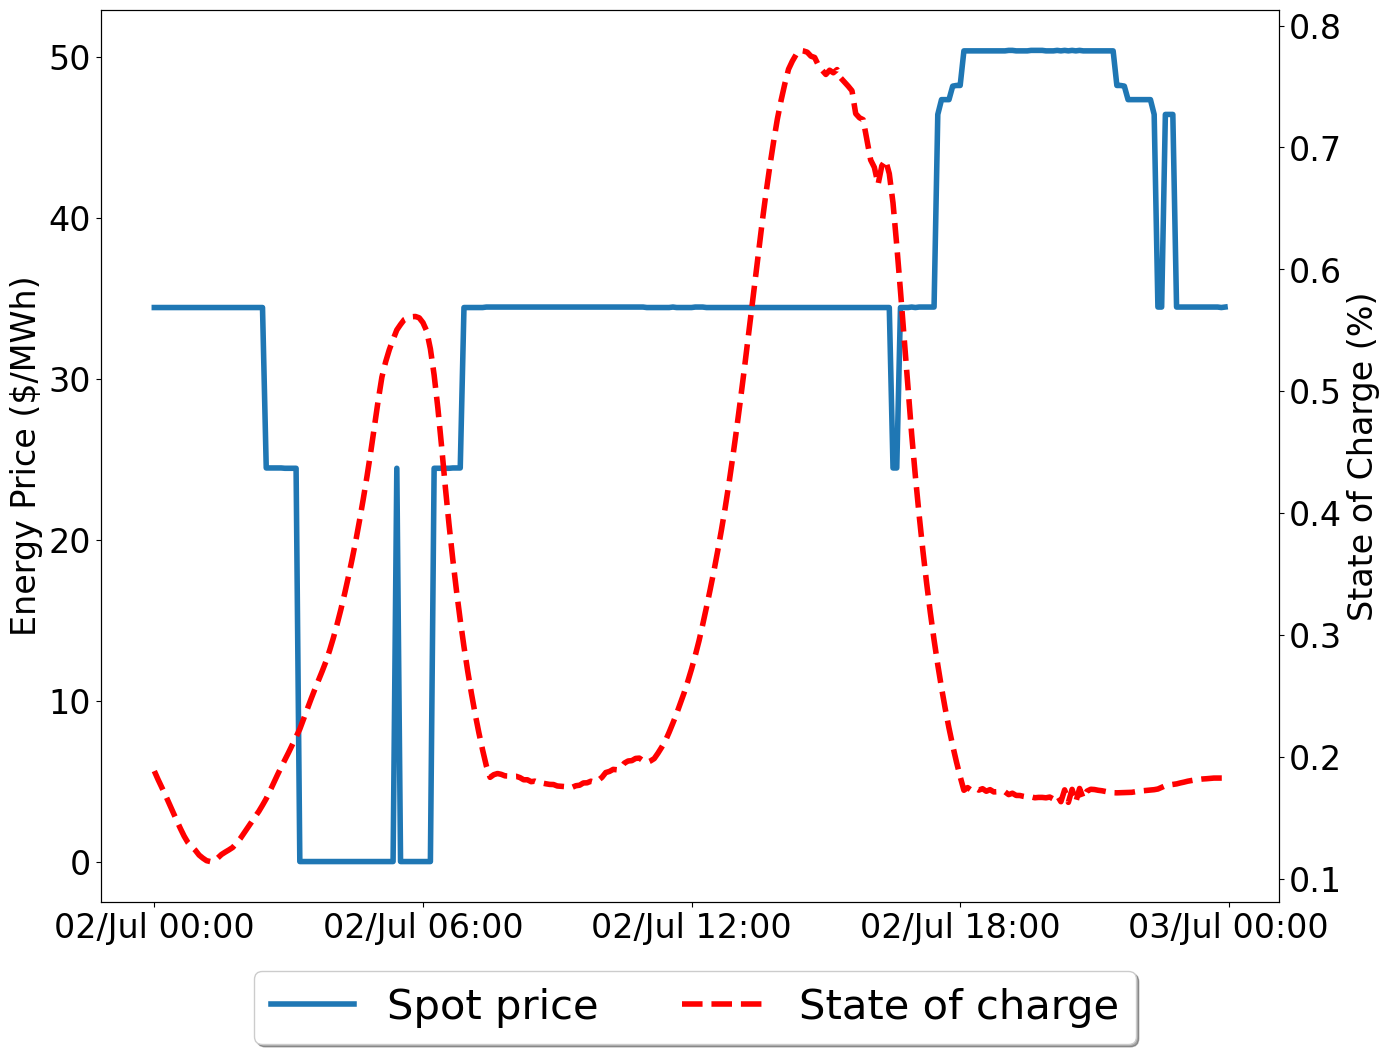

In [33]:
# Energy price and SOC chart 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

day=1

results_df_day = results_pm_energy_df.iloc[288*day:288*(day+1)]
results_df_day['SETTLEMENTDATE'] = pd.to_datetime(results_df_day['SETTLEMENTDATE'] )

fig, ax = plt.subplots(figsize=(14,10))
ax2 = ax.twinx()
ax.plot(results_df_day.SETTLEMENTDATE, results_df_day.ENERGY_price, label='Spot price', linewidth=4)
ax2.plot(results_df_day.SETTLEMENTDATE, results_df_day.SOC, '-r', label='State of charge', linewidth=4, linestyle='dashed')

# ax.set_xlabel('SETTLEMENTDATE', fontsize=16)
ax.set_ylabel('Energy Price ($/MWh)', fontsize=24)
ax2.set_ylabel('State of Charge (%)', fontsize=24)

ax.xaxis.set_tick_params(labelsize=24, rotation=0)
ax.yaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)

locater = mdates.HourLocator([6,12,18,24, 0])
myFmt = mdates.DateFormatter('%d/%b %H:%M')

ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(locater)

fig.tight_layout()
# fig.suptitle("Energy Price against SoC on Jul 2nd", size=20)
fig.subplots_adjust(top=0.95)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.01),
          fancybox=True, shadow=True, ncol=5, fontsize=30)

# fig.savefig(f'{RESULTS_PATH}/{model_name}_sampleday{day}_soc_price_profile.png', bbox_inches='tight', dpi=250)


In [10]:
mpc_results = pd.read_csv('E:/Code/Calliope/notebooks/mpc_pm_predlstm_7_1_9_1_results.csv')

results_pm_energy_df = pd.read_csv(f'{RESULTS_PATH}/price_maker_energy_only_results.csv')

model_name=f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_160000_steps'
results_pm_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')

results_pt_df = pd.read_csv(f'{RESULTS_PATH}/SAC_JOINT_JantoJune_PT_all_longtrain_322000_steps_pm_results_df.csv')

In [371]:
# Summary of all revenue
summary_revenue = pd.DataFrame()
names = ['MPC','PM-DRL','PT-DRL', 'PM-DRL-E']
data = [mpc_results, results_pm_df, results_pt_df, results_pm_energy_df]
ls=['-','--','-.',':']

for i in range(len(names)):

    #model_name=f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_{ts}_steps'
    #results_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')
    revenues = mpc.calculate_simulation_cumulative_revenue(data[i], MARKETS)
    revenues['SETTLEMENTDATE'] = pd.to_datetime(revenues['SETTLEMENTDATE'])

    revenues['FCAS_revenue'] = revenues['TOTAL'] - revenues['ENERGY_revenue']

    final_revenue = revenues[['ENERGY_revenue', 'FCAS_revenue', 'TOTAL']].tail(1)
    final_revenue['Model'] = names[i]
    summary_revenue = pd.concat([summary_revenue, final_revenue])


In [372]:
for col in ['ENERGY_revenue',	'FCAS_revenue',	'TOTAL']:
    summary_revenue[col] = summary_revenue[col].apply(lambda x: f'{round(x,2):,}')

In [378]:
print(summary_revenue.to_latex())

\begin{tabular}{lllll}
\toprule
 & ENERGY_revenue & FCAS_revenue & TOTAL & Model \\
\midrule
17569 & -3,188,796.05 & 2,024.95 & -3,186,771.1 & MPC \\
17856 & 12,440,488.5 & 153,265.01 & 12,593,753.5 & PM-DRL \\
17856 & -135,026,648.03 & 68,321.5 & -134,958,326.53 & PT-DRL \\
17856 & 21,783,517.94 & 0.0 & 21,783,517.94 & PM-DRL-E \\
\bottomrule
\end{tabular}



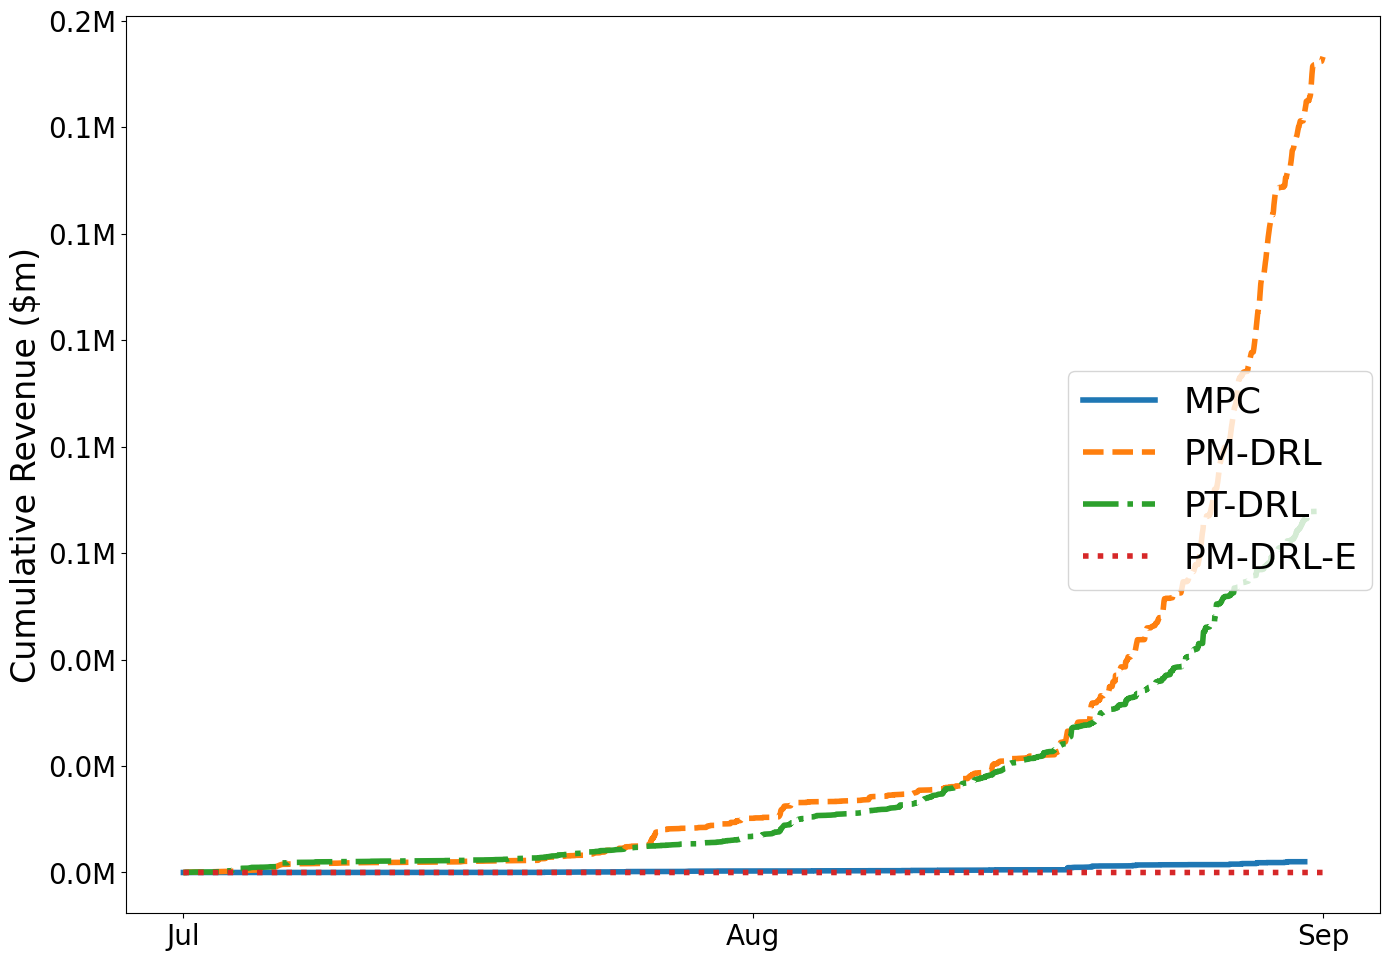

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
locater = mdates.MonthLocator(bymonth=[7,8,9])
myFmt = mdates.DateFormatter('%b')

from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(14,10))

names = ['MPC','PM-DRL','PT-DRL', 'PM-DRL-E']
data = [mpc_results, results_pm_df, results_pt_df, results_pm_energy_df]
ls=['-','--','-.',':']

for i in range(len(names)):

    #model_name=f'SAC_JOINT_JantoJune_PM_all_longtrain_arb_indicator_noreg_{ts}_steps'
    #results_df = pd.read_csv(f'{RESULTS_PATH}/{model_name}_pm_results_df.csv')
    revenues = mpc.calculate_simulation_cumulative_revenue(data[i], MARKETS)
    revenues['SETTLEMENTDATE'] = pd.to_datetime(revenues['SETTLEMENTDATE'])
    ax.plot(
        revenues.SETTLEMENTDATE, 
        revenues.TOTAL - revenues.ENERGY_revenue, 
        label=f'{names[i]}', 
        linewidth =4,
        linestyle=ls[i])
# ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label='Joint', linewidth=5, linestyle='dashed')

# ax2 = ax.twinx()

# ax2.plot(results_df.SETTLEMENTDATE, results_df.ENERGY_price, color='r', alpha=0.3, label='Energy Price')
# ax.set_xlabel('SETTLEMENTDATE', fontsize=24)
ax.set_ylabel('Cumulative Revenue ($m)', fontsize=24)
# ax.set_ylabel('Price ($/MWh)', fontsize=24)

ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(locater)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_tick_params(labelsize=16)
# ax.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

fig.tight_layout()
# fig.suptitle("Price-Taker Energy-Reg Bidding Cumulative Revenue Jul-Aug", size=26)
fig.subplots_adjust(top=0.95)
fig.legend(fontsize=26, loc='center right')
plt.show()